# [Late Chunking (AKA Chunked Pooling)](https://arxiv.org/pdf/2409.04701)

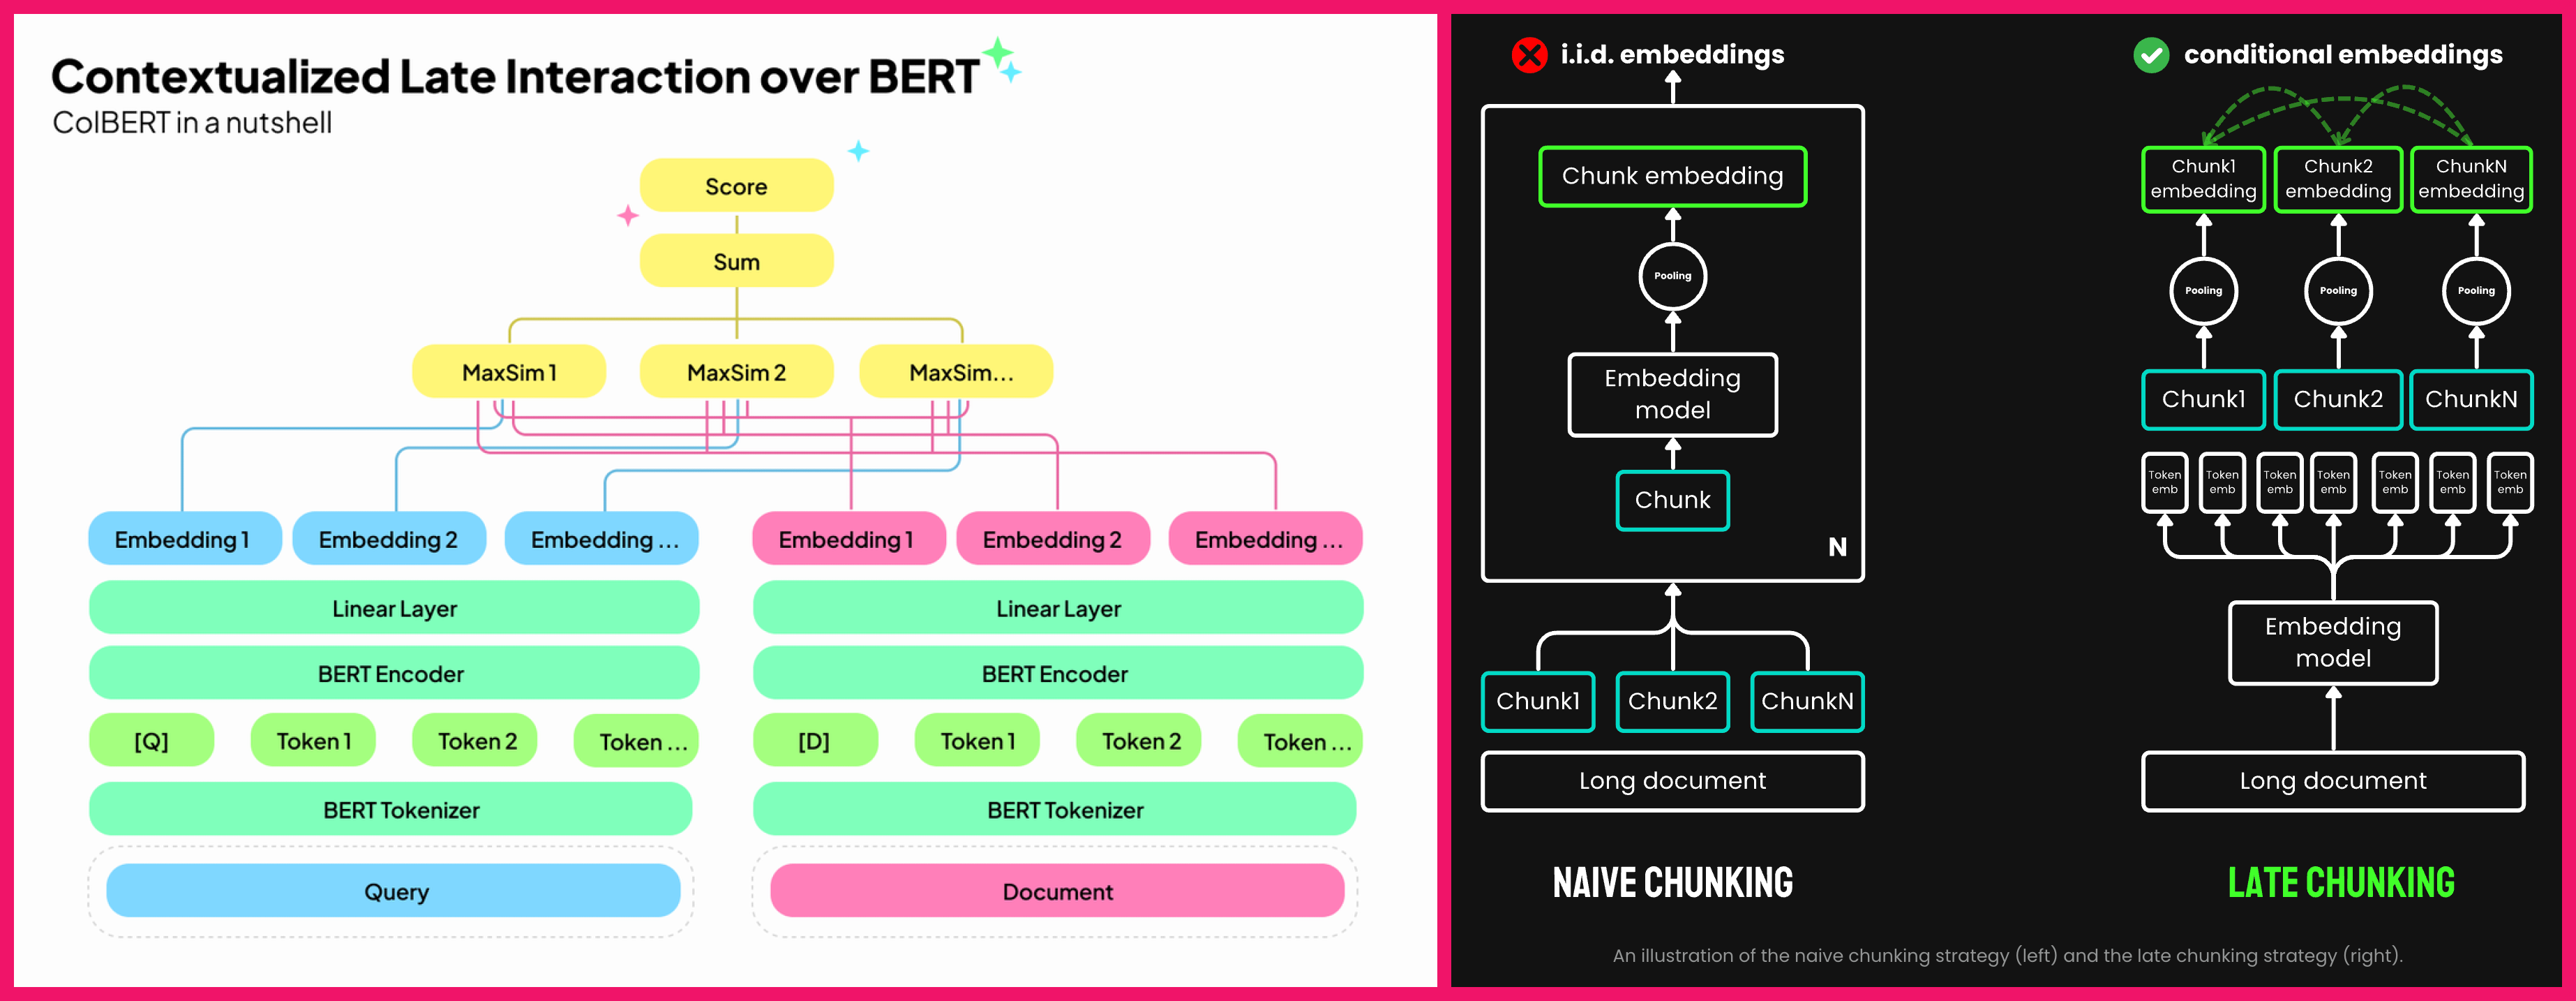

In [1]:
!pip install transformers datasets einops lancedb sentence-transformers -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.0/30.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 5.6 MB/s eta 0:00:00


In [2]:
from transformers import AutoModel
from transformers import AutoTokenizer
import pandas as pd
import lancedb

pd.set_option("max_colwidth", 200)

# Any model which supports mean pooling can be used here. However, models with a large maximum context-length are preferred
tokenizer = AutoTokenizer.from_pretrained(
    "jinaai/jina-embeddings-v2-base-en", trust_remote_code=True
)
model = AutoModel.from_pretrained(
    "jinaai/jina-embeddings-v2-base-en", trust_remote_code=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

# Helpers

Now we define the text which we want to encode and split it into chunks. The `chunk_by_sentences` function also returns the span annotations. Those specify the number of tokens per chunk which is needed for the chunked pooling.

In [3]:
def chunk_by_sentences(input_text: str, tokenizer: callable):
    """
    Split the input text into sentences using the tokenizer
    args:
      input_text: The text snippet to split into sentences
      tokenizer: The tokenizer to use
    return: A tuple containing the list of text chunks and their corresponding token spans
    """
    inputs = tokenizer(input_text, return_tensors="pt", return_offsets_mapping=True)
    punctuation_mark_id = tokenizer.convert_tokens_to_ids(".")
    sep_id = tokenizer.convert_tokens_to_ids("[SEP]")
    token_offsets = inputs["offset_mapping"][0]
    token_ids = inputs["input_ids"][0]
    chunk_positions = [
        (i, int(start + 1))
        for i, (token_id, (start, end)) in enumerate(zip(token_ids, token_offsets))
        if token_id == punctuation_mark_id
        and (
            token_offsets[i + 1][0] - token_offsets[i][1] > 0
            or token_ids[i + 1] == sep_id
        )
    ]
    chunks = [
        input_text[x[1] : y[1]]
        for x, y in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    span_annotations = [
        (x[0], y[0]) for (x, y) in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    return chunks, span_annotations


def late_chunking(model_output, span_annotation: list, max_length=None):
    token_embeddings = model_output[0]
    outputs = []
    for embeddings, annotations in zip(token_embeddings, span_annotation):
        if (
            max_length is not None
        ):  # remove annotations which go bejond the max-length of the model
            annotations = [
                (start, min(end, max_length - 1))
                for (start, end) in annotations
                if start < (max_length - 1)
            ]
        pooled_embeddings = [
            embeddings[start:end].sum(dim=0) / (end - start)
            for start, end in annotations
            if (end - start) >= 1
        ]
        pooled_embeddings = [
            embedding.detach().cpu().numpy() for embedding in pooled_embeddings
        ]
        outputs.append(pooled_embeddings)

    return outputs

In [16]:
# Let's assume this is a long document and it has 4 non overlapping chunks to understand how and where you can use it
dummy_long_document = """Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history. It's Capital is Berlin and is pronounced as 'ber-liin' in German. The capital is the largest city of Germany, both by area and by population. Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits. The city is also one of the states of Germany, and is the third smallest state in the country in terms of area."""

chunks, span_annotations = chunk_by_sentences(dummy_long_document, tokenizer)
print('Chunks:\n- "' + '"\n- "'.join(chunks) + '"')

Chunks:
- "Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history."
- " It's Capital is Berlin and is pronounced as 'ber-liin' in German."
- " The capital is the largest city of Germany, both by area and by population."
- " Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits."
- " The city is also one of the states of Germany, and is the third smallest state in the country in terms of area."


As you can see above, in the second chunk, **Berlin** is mentioned explicitely but in the second and third one, the pronouns are used

Now we encode the chunks with the traditional and the context-sensitive chunked pooling method:

In [17]:
# !rm -rf ./db
db = lancedb.connect("./db")

In [18]:
vanilla_chunk_embeddings = model.encode(chunks)

vanilla_data = []
for index, chunk in enumerate(chunks):
    vanilla_data.append(
        {
            "text": chunk,
            "vector": vanilla_chunk_embeddings[index],
        }
    )


vanilla_table = db.create_table("vanilla_table", data=vanilla_data)

In [19]:
inputs = tokenizer(dummy_long_document, return_tensors="pt")
model_output = model(**inputs)
late_chunk_embeddings = late_chunking(model_output, [span_annotations])[0]

late_chunk_data = []
for index, chunk in enumerate(chunks):
    late_chunk_data.append(
        {
            "text": chunk,
            "vector": late_chunk_embeddings[index],
        }
    )


late_chunk_table = db.create_table("late_chunk_table", data=late_chunk_data)

In [20]:
QUERY_EMBED_1 = model.encode(
    "What are some of the attributes about the capital of a country whose Oktoberfest is famous?"
)
QUERY_EMBED_2 = model.encode(
    "What are some of the attributes about capital of Germany?"
)
QUERY_EMBED_3 = model.encode("What are some of the attributes about Berlin?")

METRIC = "cosine"  # "cosine" "l2" "dot"

## Query -> `What are some of the attributes about the capital of a country whose Oktoberfest is famous?`

In [21]:
vanilla_table.search(QUERY_EMBED_1).metric(METRIC).to_pandas().drop("vector", axis=1)

,text,_distance
0,"The capital is the largest city of Germany, both by area and by population.",0.209394
1,"Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history.",0.242262
2,It's Capital is Berlin and is pronounced as 'ber-liin' in German.,0.262366
3,"The city is also one of the states of Germany, and is the third smallest state in the country in terms of area.",0.262574
4,"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",0.268439


In [22]:
late_chunk_table.search(QUERY_EMBED_1).metric(METRIC).to_pandas().drop("vector", axis=1)

,text,_distance
0,"The city is also one of the states of Germany, and is the third smallest state in the country in terms of area.",0.190387
1,"The capital is the largest city of Germany, both by area and by population.",0.202577
2,"Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history.",0.210747
3,"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",0.212762
4,It's Capital is Berlin and is pronounced as 'ber-liin' in German.,0.244450


## Query -> `What are some of the attributes about capital of Germany?`

In [23]:
vanilla_table.search(QUERY_EMBED_2).metric(METRIC).to_pandas().drop("vector", axis=1)

,text,_distance
0,"The capital is the largest city of Germany, both by area and by population.",0.141102
1,It's Capital is Berlin and is pronounced as 'ber-liin' in German.,0.201108
2,"Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history.",0.210599
3,"The city is also one of the states of Germany, and is the third smallest state in the country in terms of area.",0.236823
4,"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",0.296898


In [24]:
late_chunk_table.search(QUERY_EMBED_2).metric(METRIC).to_pandas().drop("vector", axis=1)

,text,_distance
0,"The city is also one of the states of Germany, and is the third smallest state in the country in terms of area.",0.120223
1,"The capital is the largest city of Germany, both by area and by population.",0.140857
2,"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",0.156581
3,"Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history.",0.176424
4,It's Capital is Berlin and is pronounced as 'ber-liin' in German.,0.184420


## Query -> `What are some of the attributes about Berlin?`

In [25]:
vanilla_table.search(QUERY_EMBED_3).metric(METRIC).to_pandas().drop("vector", axis=1)

,text,_distance
0,It's Capital is Berlin and is pronounced as 'ber-liin' in German.,0.201292
1,"The capital is the largest city of Germany, both by area and by population.",0.232989
2,"Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history.",0.238901
3,"The city is also one of the states of Germany, and is the third smallest state in the country in terms of area.",0.250955
4,"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",0.287352


In [26]:
late_chunk_table.search(QUERY_EMBED_3).metric(METRIC).to_pandas().drop("vector", axis=1)

,text,_distance
0,"The city is also one of the states of Germany, and is the third smallest state in the country in terms of area.",0.159417
1,"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",0.196069
2,"The capital is the largest city of Germany, both by area and by population.",0.199308
3,"Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history.",0.209480
4,It's Capital is Berlin and is pronounced as 'ber-liin' in German.,0.235123


# Results

You see, in the Vanilla Chunking, in the 3rd query where `Berlin` is explicitly mentioned, the naive chunking gave Top-3 results where there are no specifications about Berlin mentioned BUT only the name is mentioned.

Now, when you look at the Late chunking, Top-3 results are specifically about the specifications even though the word is out of scope.

Also, the main thing to look at is the cosine similarity where in the Naive chunking, the chunk:
> Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.

is having last place with distance `0.28` is very relevant to the query and for a turn of surprise, it is having more distance than the chunk:

> Germany is known for it's automative industry, jevlin throwers, football teams and a lot more things from the history

which has a distanxe of `0.23`

While in the Late Chunking, it perfectly aligns. So it also works as a contextual reranker within